# Exploring Wikipedia clickstream data: English Wiki in December 2018    

## Exploring obscure browsing   

### 1. Introduction   

This notebook explores obscure browsing within the article communities found in the English Wikipedia clickstream dataset for December 2018.  
This is the 6th part of a project about the usage patterns of Wikipedia.  
The preceding parts are:  
1. [Data quality analysis of available datasets](data_quality_analysis.ipynb)  
2. [Exploratory data analysis of the English Wikipedia clickstream dataset for December 2018](English_Wikipedia_EDA.ipynb)  
3. [Graph modeling of the English Wikipedia clickstream dataset for December 2018](English_Wikipedia_graph_modeling_AWS.ipynb)  
4. [Network analysis of the English Wikipedia clickstream dataset](English_Wikipedia_network_analysis_AWS.ipynb)  
5. [Defining community topics with NLP](English_Wikipedia_NLP_AWS.ipynb)

[Deep web](https://en.wikipedia.org/wiki/Deep_web) is a term used to describe the parts of the world wide web that are not indexed by the standard web search engines. It has a counterpart called the [surface web](https://en.wikipedia.org/wiki/Surface_web), which is the part of the web that anyone can access.  
While all of the Wikipedia articles we have in the clickstream dataset clearly are in the surface web, some of them were directly accessed from the external web (search engines, websites, etc.), and some were only accessed from within Wikipedia, by browsing from other Wikipedia articles. In this notebook, we'll focus on this distinction among the articles, and we'll borrow from the "deep web"/"surface web" terminology and call the set of articles that were accessed directly from outside Wikipedia the **surface Wiki**, and the articles that were only accessed from inside of Wikipedia the **deep Wiki**.

We'll look at how much of Wikipedia article views are in the surface Wiki vs deep Wiki. We'll also find out how "far" into deep Wiki the users have browsed in December 2018.

#### Notebook contents:  

1. [Introduction](#1.-Introduction)  
2. [Notebook setup](#2.-Notebook-setup)  
3. [Analysis](#3.-Analysis)  
   3.1 [Deep Wiki stats per community](#3.1-Deep-Wiki-stats-per-community)  
   3.2 [Plots](#3.2-Plots)  
   3.3 [Deep Wiki shell decomposition](#3.3-Deep-Wiki-shell-decomposition)  
   3.4 [Finding the clickstream path to the farthest deep Wiki article](#3.4-Finding-the-clickstream-path-to-the-farthest-deep-Wiki-article)
4. [Summary](#4.-Summary)
5. [Next steps](#5.-Next-steps)

### 2. Notebook setup  

#### Imports

In [1]:
import pandas as pd
import numpy as np

import re
import json

from py2neo import authenticate, Graph, Node, Relationship


import os
import csv
import pickle

from time import sleep
from timeit import default_timer as timer
from datetime import datetime

from IPython.display import display, HTML

# custom general helper functions for this project
import custom_utils as cu
import importlib


In [2]:
from collections import defaultdict

In [31]:

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [3]:
# reload imports as needed
importlib.reload(cu);

#### Settings

In [4]:
# set up Pandas options
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 3)
pd.options.display.float_format = '{:.2f}'.format

In [5]:
pd.options.display.max_colwidth = 100

In [32]:
# Customize matplotlib default settings
matplotlib.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,10)

#### Connect to neo4j

In [9]:
n4j_cred = cu.read_n4jpass()

# set up authentication parameters
authenticate("localhost:7474", n4j_cred["user"], n4j_cred["password"])

# connect to authenticated graph database
graph = Graph("http://localhost:7474/db/data/")

# test query
r = graph.data('CALL db.indexes;')
pd.DataFrame(r)

,description,failureMessage,id,indexName,progress,properties,provider,state,tokenNames,type
0,INDEX ON :Article(title),,1,index_1,100.00,[title],"{'version': '1.0', 'key': 'native-btree'}",ONLINE,[Article],node_unique_property


#### Pull the input data from neo4j

In [13]:
# get a listing of nodes, their partitions, communities and incoming traffic
start_time = timer()
q = """
    MATCH (a:Article)
    WHERE exists(a.louvain_community)
    RETURN 
        a.title as title,
        a.louvain_community as louvain_community, 
            
        a.external_search_traffic as external_search_traffic,
        a.external_website_traffic as external_website_traffic,
        a.unknown_external_traffic as unknown_external_traffic,
        a.empty_referer_traffic as empty_referer_traffic,
        a.other_wikimedia_traffic as other_wikimedia_traffic,
        
        a.link_in_traffic as link_in_traffic,
        a.search_in_traffic as search_in_traffic,
        a.search_traffic_from_main_page as search_traffic_from_main_page
    ORDER BY external_search_traffic IS NOT NULL desc, external_search_traffic desc;
    """
r = graph.data(q)
nodes_for_deep_wiki = pd.DataFrame(r)

print("Number of articles:",len(nodes_for_deep_wiki))

cu.printRunTime(start_time)

Number of articles: 2729767


Runtime: 5.09 min



### 3. Analysis  

#### 3.1 Deep Wiki stats per community

In [14]:
nodes_for_deep_wiki.fillna(0, inplace=True)

In [15]:
nodes_for_deep_wiki["total_external_visits"] = (  nodes_for_deep_wiki.external_website_traffic
                                                + nodes_for_deep_wiki.unknown_external_traffic
                                                + nodes_for_deep_wiki.external_search_traffic
                                                + nodes_for_deep_wiki.empty_referer_traffic
                                                + nodes_for_deep_wiki.other_wikimedia_traffic
                                               )

nodes_for_deep_wiki["total_internal_visits"] = (  nodes_for_deep_wiki.search_in_traffic
                                                + nodes_for_deep_wiki.search_traffic_from_main_page
                                                + nodes_for_deep_wiki.link_in_traffic
                                               )

nodes_for_deep_wiki.head()

,empty_referer_traffic,external_search_traffic,external_website_traffic,link_in_traffic,louvain_community,other_wikimedia_traffic,search_in_traffic,search_traffic_from_main_page,title,unknown_external_traffic,total_external_visits,total_internal_visits
0,804462.00,4576854.00,38972.00,1108189.00,3,109536.00,5630.00,220667.00,George_H._W._Bush,27129.00,5556953.00,1334486.00
1,990366.00,3538068.00,9764.00,639353.00,4,45797.00,6451.00,15162.00,Jason_Momoa,16300.00,4600295.00,660966.00
2,793408.00,3475113.00,19564.00,223635.00,9,44383.00,23563.00,13367.00,2.0_(film),182358.00,4514826.00,260565.00
3,586351.00,3251996.00,7054.00,682992.00,4,127234.00,10416.00,33848.00,Bird_Box_(film),10447.00,3983082.00,727256.00
4,492341152.00,3020671.00,677294.00,31170.00,1,8826536.00,0.00,0.00,Main_Page,81647.00,504947300.00,31170.00


In [16]:
nodes_for_deep_wiki[nodes_for_deep_wiki.total_external_visits == 0][:10]

,empty_referer_traffic,external_search_traffic,external_website_traffic,link_in_traffic,louvain_community,other_wikimedia_traffic,search_in_traffic,search_traffic_from_main_page,title,unknown_external_traffic,total_external_visits,total_internal_visits
2708842,0.00,0.00,0.00,0.00,7,0.00,0.00,0.00,Myktybek_Abdyldayev,0.00,0.00,0.00
2708843,0.00,0.00,0.00,0.00,3,0.00,0.00,0.00,Stockholm_attack,0.00,0.00,0.00
2708844,0.00,0.00,0.00,34.00,13,0.00,0.00,0.00,Strategic_Command_(disambiguation),0.00,0.00,34.00
2708845,0.00,0.00,0.00,0.00,1,0.00,0.00,0.00,"Orders,_decorations,_and_medals_of_Turkmenistan",0.00,0.00,0.00
2708846,0.00,0.00,0.00,108.00,3,0.00,0.00,0.00,"John_Lyon,_4th_Lord_Glamis",0.00,0.00,108.00
2708847,0.00,0.00,0.00,39.00,17,0.00,0.00,0.00,United_Front_(China)_(disambiguation),0.00,0.00,39.00
2708848,0.00,0.00,0.00,14.00,4,0.00,0.00,0.00,Frank_Mancuso_(disambiguation),0.00,0.00,14.00
2708849,0.00,0.00,0.00,29.00,2,0.00,0.00,0.00,Tilsit_(disambiguation),0.00,0.00,29.00
2708850,0.00,0.00,0.00,43.00,4,0.00,0.00,0.00,Dramarama_(disambiguation),0.00,0.00,43.00
2708851,0.00,0.00,0.00,0.00,22,0.00,0.00,0.00,V50,0.00,0.00,0.00


In [17]:
community_deepWiki_stats = nodes_for_deep_wiki[nodes_for_deep_wiki.total_external_visits == 0] \
    .groupby("louvain_community")[["title"]].count()
community_deepWiki_stats.columns = ["deep_wiki_articles_count"]

community_deepWiki_stats[:5]

,deep_wiki_articles_count
louvain_community,
0,248
1,1099
2,2423
3,3860
4,1020


In [18]:
len(community_deepWiki_stats)

293

In [19]:
pd.options.display.float_format = '{:.8f}'.format

In [20]:
community_deepWiki_stats["articles_count"] = nodes_for_deep_wiki.groupby("louvain_community")["title"].count()
community_deepWiki_stats["deep_wiki_articles_proportion"] = \
    community_deepWiki_stats.deep_wiki_articles_count / community_deepWiki_stats.articles_count


community_deepWiki_stats["deep_wiki_internal_visits"] = \
    nodes_for_deep_wiki[nodes_for_deep_wiki.total_external_visits == 0] \
    .groupby("louvain_community")["total_internal_visits"] \
    .sum().astype("int64")
community_deepWiki_stats["total_internal_visits"] = \
    nodes_for_deep_wiki.groupby("louvain_community")["total_internal_visits"].sum().astype("int64")
community_deepWiki_stats["deep_wiki_internal_visits_proportion"] = \
    community_deepWiki_stats.deep_wiki_internal_visits / community_deepWiki_stats.total_internal_visits

    
    
community_deepWiki_stats["deep_wiki_link_in_traffic"] = \
    nodes_for_deep_wiki[nodes_for_deep_wiki.total_external_visits == 0] \
    .groupby("louvain_community")["link_in_traffic"] \
    .sum().astype("int64")
community_deepWiki_stats["link_in_traffic"] = nodes_for_deep_wiki.groupby("louvain_community")["link_in_traffic"] \
                                              .sum().astype("int64")
community_deepWiki_stats["deep_wiki_link_in_traffic_proportion"] = \
    community_deepWiki_stats.deep_wiki_link_in_traffic / community_deepWiki_stats.link_in_traffic

    

community_deepWiki_stats["deep_wiki_search_in_traffic"] = \
    nodes_for_deep_wiki[nodes_for_deep_wiki.total_external_visits == 0] \
    .groupby("louvain_community")["search_in_traffic"] \
    .sum().astype("int64")
community_deepWiki_stats["search_in_traffic"] = nodes_for_deep_wiki.groupby("louvain_community")["search_in_traffic"] \
                                              .sum().astype("int64")
community_deepWiki_stats["deep_wiki_search_in_traffic_proportion"] = \
    community_deepWiki_stats.deep_wiki_search_in_traffic / community_deepWiki_stats.search_in_traffic

    
    
community_deepWiki_stats.head()

,deep_wiki_articles_count,articles_count,deep_wiki_articles_proportion,deep_wiki_internal_visits,total_internal_visits,deep_wiki_internal_visits_proportion,deep_wiki_link_in_traffic,link_in_traffic,deep_wiki_link_in_traffic_proportion,deep_wiki_search_in_traffic,search_in_traffic,deep_wiki_search_in_traffic_proportion
louvain_community,,,,,,,,,,,,
0,248,29397,0.00843623,3435,5306439,0.00064733,3414,5057107,0.00067509,21,29778,0.00070522
1,1099,218001,0.00504126,19950,101941984,0.00019570,19691,95420595,0.00020636,259,1056534,0.00024514
2,2423,209065,0.01158970,39438,100235624,0.00039345,38916,96546076,0.00040308,522,1568306,0.00033284
3,3860,507642,0.00760378,64629,339915502,0.00019013,62693,329625267,0.00019019,1916,4188154,0.00045748
4,1020,267541,0.00381250,18366,472694667,0.00003885,18132,461475849,0.00003929,234,3938984,0.00005941


In [24]:
nodes_for_deep_wiki.fillna(0, inplace=True)

In [25]:
community_deepWiki_stats.describe()

/home/arinai/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,deep_wiki_articles_count,articles_count,deep_wiki_articles_proportion,deep_wiki_internal_visits,total_internal_visits,deep_wiki_internal_visits_proportion,deep_wiki_link_in_traffic,link_in_traffic,deep_wiki_link_in_traffic_proportion,deep_wiki_search_in_traffic,search_in_traffic,deep_wiki_search_in_traffic_proportion
count,293.00000000,293.00000000,293.00000000,293.00000000,293.00000000,293.00000000,293.00000000,293.00000000,293.00000000,293.00000000,293.00000000,79.00000000
mean,71.41638225,9264.49488055,0.12533002,1233.52901024,6034239.98634812,0.08369043,1212.45051195,5859586.15358362,0.08354263,19.91808874,63954.11604096,0.02066294
std,359.27948827,46608.41982077,0.11026480,6258.85888791,37637817.34217964,0.11221609,6139.12717474,36625286.20176264,0.11261909,130.41729697,375719.72973362,0.13163346
min,1.00000000,3.00000000,0.00151883,0.00000000,46.00000000,0.00000000,0.00000000,46.00000000,0.00000000,0.00000000,0.00000000,0.00000000
25%,1.00000000,7.00000000,0.04545455,13.00000000,186.00000000,0.01059536,13.00000000,185.00000000,0.00961538,0.00000000,0.00000000,nan
50%,1.00000000,13.00000000,0.10000000,21.00000000,404.00000000,0.04411765,21.00000000,403.00000000,0.04333333,0.00000000,0.00000000,nan
75%,3.00000000,35.00000000,0.16666667,47.00000000,1869.00000000,0.11538462,47.00000000,1824.00000000,0.11475410,0.00000000,11.00000000,nan
max,3860.00000000,507642.00000000,0.60000000,64629.00000000,472694667.00000000,0.81967213,62693.00000000,461475849.00000000,0.81967213,1916.00000000,4188154.00000000,1.00000000


In [26]:
# unpickle
with open("pickles/en_1218_louvain_community_topics_dict.pkl", 'rb') as picklefile: 
    community_topics_dict = pickle.load(picklefile)

community_topics_dict[22]["topic_words"][:5]

['grand', 'prix', 'championship', 'seri', 'engin']

In [27]:
community_ids = community_deepWiki_stats.index.values
for i in community_ids:
    community_deepWiki_stats.at[i, "topic_words"] = " ".join(community_topics_dict[i]["topic_words"])
       

In [28]:
community_deepWiki_stats[:10]

,deep_wiki_articles_count,articles_count,deep_wiki_articles_proportion,deep_wiki_internal_visits,total_internal_visits,deep_wiki_internal_visits_proportion,deep_wiki_link_in_traffic,link_in_traffic,deep_wiki_link_in_traffic_proportion,deep_wiki_search_in_traffic,search_in_traffic,deep_wiki_search_in_traffic_proportion,topic_words
louvain_community,,,,,,,,,,,,,
0,248,29397,0.00843623,3435,5306439,0.00064733,3414,5057107,0.00067509,21,29778,0.00070522,station railway class line rail metro list park train transport british london south road tram c...
1,1099,218001,0.00504126,19950,101941984,0.00019570,19691,95420595,0.00020636,259,1056534,0.00024514,list disambigu softwar power station number engin space unit program network model theorem group...
2,2423,209065,0.01158970,39438,100235624,0.00039345,38916,96546076,0.00040308,522,1568306,0.00033284,list disambigu syndrom nation park diseas food black acid hospit state red white cell medic dog ...
3,3860,507642,0.00760378,64629,339915502,0.00019013,62693,329625267,0.00019019,1916,4188154,0.00045748,list unit state footbal elect nation th constitu parti battl john film st district war cup disam...
4,1020,267541,0.00381250,18366,472694667,0.00003885,18132,461475849,0.00003929,234,3938984,0.00005941,film list seri tv actor comic season award disambigu episod school john charact novel man star l...
5,2083,223864,0.00930476,45345,154836215,0.00029286,45184,151652674,0.00029794,161,930331,0.00017306,album song band list discographi love music live musician record tour disambigu ep best world aw...
6,357,81807,0.00436393,5570,28801559,0.00019339,5474,28116882,0.00019469,96,320477,0.00029955,univers school list colleg bank institut compani state intern educ group law technolog scienc un...
7,2246,302120,0.00743413,40832,144380673,0.00028281,39944,140416238,0.00028447,648,1257742,0.00051521,list disambigu church al john novel saint languag histori st film battl ii cathol roman book wil...
8,671,73172,0.00917017,10273,37724675,0.00027232,9979,36767267,0.00027141,270,286442,0.00094260,airport air uss list class hms airlin intern squadron flight submarin forc aircraft ship th avia...


In [69]:
community_deepWiki_stats.sort_values("deep_wiki_articles_proportion", ascending=False)[:50]

,deep_wiki_articles_count,articles_count,deep_wiki_articles_proportion,deep_wiki_link_in_traffic,link_in_traffic,deep_wiki_link_in_traffic_proportion,deep_wiki_search_in_traffic,search_in_traffic,deep_wiki_search_in_traffic_proportion,topic_words
louvain_community,,,,,,,,,,
1573,12,20,0.60000000,146,264,0.55303030,0,0,nan,footbal sewane team tiger
1369,4,8,0.50000000,59,101,0.58415842,0,0,nan,armenian film list
1412,4,8,0.50000000,135,259,0.52123552,0,0,nan,canton boutonn et mignon mell autiz égray bell cell sur arrondiss niort frontenay rohan la niort...
622,3,6,0.50000000,36,76,0.47368421,0,0,nan,minyor fc pernik martin vasilev stadium aleksandar manolov petar tonchev april bear footbal ivan...
1371,2,4,0.50000000,50,61,0.81967213,0,0,nan,ensembl revolutionari album vietnam peopl republ
708,17,36,0.47222222,224,559,0.40071556,0,0,nan,desulfobact desulfomonil desulfatiferula desulfococcus hydrogenophilus desulfosarcina desulfonem...
881,5,11,0.45454545,80,262,0.30534351,0,0,nan,album hiss purl bird maya mar water announc public servic bias high hissteria ep lizard loung mo...
1124,12,27,0.44444444,249,1033,0.24104550,0,0,nan,ep jong mauric reek vomit gnaw tongu like issei sagawa eschatolog scatolog seirom dread magnific...
1419,3,7,0.42857143,55,148,0.37162162,0,0,nan,album idol nasti cruel intent gigolo parol vicious hero sale kalifornia boy town


In [70]:
community_deepWiki_stats[community_deepWiki_stats.articles_count >= 100].sort_values("deep_wiki_articles_proportion", ascending=False)[:50]

,deep_wiki_articles_count,articles_count,deep_wiki_articles_proportion,deep_wiki_link_in_traffic,link_in_traffic,deep_wiki_link_in_traffic_proportion,deep_wiki_search_in_traffic,search_in_traffic,deep_wiki_search_in_traffic_proportion,topic_words
louvain_community,,,,,,,,,,
196,4,111,0.03603604,61,1824,0.03344298,0,64,0.00000000,art tabl year archaeolog architectur
39,92,4444,0.02070207,1476,1768472,0.00083462,12,15455,0.00077645,scout list mount mountain climb knot everest swiss world switzerland peak feder glacier hitch bo...
130,6,297,0.02020202,78,14247,0.00547484,0,37,0.00000000,list microbacterium haiti album flindersia dangi colton drug forest meyer krameria richard dorst...
12,990,49144,0.02014488,16901,8664354,0.00195064,86,81325,0.00105749,olymp championship summer men world women game athlet metr open winter cup singl list swim tenni...
298,2,102,0.01960784,32,8865,0.00360970,0,28,0.00000000,album sea big great song musician spirit west newfoundland doug john mann maclean tara simani mu...
233,2,108,0.01851852,31,17277,0.00179429,0,115,0.00000000,tueni delaney spain jam court pragu list tower maryknol ford keat suprem build slaney el ezra ja...
173,3,188,0.01595745,43,12026,0.00357559,0,0,nan,municip fk macedonia region statist footbal macedonian leagu republ skopj kavadarci second berov...
108,5,431,0.01160093,108,59327,0.00182042,0,271,0.00000000,school colleg time team maldiv list seri sri lanka maldivian moham intern ibrahim elect central ...
2,2423,209065,0.01158970,38916,96546076,0.00040308,522,1568306,0.00033284,list disambigu syndrom nation park diseas food black acid hospit state red white cell medic dog ...


In [71]:
community_deepWiki_stats[community_deepWiki_stats.articles_count >= 1000].sort_values("deep_wiki_articles_proportion", ascending=False)[:50]

,deep_wiki_articles_count,articles_count,deep_wiki_articles_proportion,deep_wiki_link_in_traffic,link_in_traffic,deep_wiki_link_in_traffic_proportion,deep_wiki_search_in_traffic,search_in_traffic,deep_wiki_search_in_traffic_proportion,topic_words
louvain_community,,,,,,,,,,
39,92,4444,0.02070207,1476,1768472,0.00083462,12,15455,0.00077645,scout list mount mountain climb knot everest swiss world switzerland peak feder glacier hitch bo...
12,990,49144,0.02014488,16901,8664354,0.00195064,86,81325,0.00105749,olymp championship summer men world women game athlet metr open winter cup singl list swim tenni...
2,2423,209065,0.01158970,38916,96546076,0.00040308,522,1568306,0.00033284,list disambigu syndrom nation park diseas food black acid hospit state red white cell medic dog ...
19,256,22194,0.01153465,4210,5019260,0.00083877,94,105863,0.00088794,footbal leagu cup nation malaysia district stadium championship fc list team asian afc station f...
34,23,2263,0.01016350,282,463902,0.00060789,0,6257,0.00000000,hurrican season cyclon typhoon tropic atlant storm pacif list ocean indian north south region au...
44,30,3171,0.00946074,555,2110845,0.00026293,0,21992,0.00000000,snooker dart world championship player master open pdc cup uk bdo leagu pool grand rank season t...
5,2083,223864,0.00930476,45184,151652674,0.00029794,161,930331,0.00017306,album song band list discographi love music live musician record tour disambigu ep best world aw...
47,15,1629,0.00920810,202,408813,0.00049411,0,4694,0.00000000,comic asterix kingdom unit novel list tintin jeev new york charact time adventur seri jack magaz...
8,671,73172,0.00917017,9979,36767267,0.00027141,270,286442,0.00094260,airport air uss list class hms airlin intern squadron flight submarin forc aircraft ship th avia...


In [72]:
community_deepWiki_stats[community_deepWiki_stats.articles_count >= 10000].sort_values("deep_wiki_articles_proportion", ascending=False)[:50]

,deep_wiki_articles_count,articles_count,deep_wiki_articles_proportion,deep_wiki_link_in_traffic,link_in_traffic,deep_wiki_link_in_traffic_proportion,deep_wiki_search_in_traffic,search_in_traffic,deep_wiki_search_in_traffic_proportion,topic_words
louvain_community,,,,,,,,,,
12,990,49144,0.02014488,16901,8664354,0.00195064,86,81325,0.00105749,olymp championship summer men world women game athlet metr open winter cup singl list swim tenni...
2,2423,209065,0.01158970,38916,96546076,0.00040308,522,1568306,0.00033284,list disambigu syndrom nation park diseas food black acid hospit state red white cell medic dog ...
19,256,22194,0.01153465,4210,5019260,0.00083877,94,105863,0.00088794,footbal leagu cup nation malaysia district stadium championship fc list team asian afc station f...
5,2083,223864,0.00930476,45184,151652674,0.00029794,161,930331,0.00017306,album song band list discographi love music live musician record tour disambigu ep best world aw...
8,671,73172,0.00917017,9979,36767267,0.00027141,270,286442,0.00094260,airport air uss list class hms airlin intern squadron flight submarin forc aircraft ship th avia...
33,105,12265,0.00856095,1865,1736667,0.00107390,25,18993,0.00131627,song eurovis contest tv list radio album televis junior channel singer newspap seri band media u...
10,1972,233396,0.00844916,29658,84128861,0.00035253,568,932688,0.00060899,state list new counti school unit california york station park district elect john citi texa hig...
0,248,29397,0.00843623,3414,5057107,0.00067509,21,29778,0.00070522,station railway class line rail metro list park train transport british london south road tram c...
21,361,44664,0.00808257,5638,8931956,0.00063122,202,209524,0.00096409,cricket rugbi list new south australia australian union leagu team wale nation cup footbal world...


In [73]:
community_deepWiki_stats.deep_wiki_articles_proportion.round().value_counts()

0.00000000    292
1.00000000      1
Name: deep_wiki_articles_proportion, dtype: int64

In [29]:
pd.options.display.float_format = '{:.2f}'.format

community_deepWiki_stats.deep_wiki_articles_proportion.round(2).value_counts().sort_index(ascending=False)

0.60     1
0.50     4
0.47     1
0.45     1
0.44     1
0.43     1
0.40     2
0.38     1
0.36     1
0.33     8
0.32     1
0.30     1
0.29     2
0.25    19
0.24     1
0.23     1
0.22     2
0.21     2
0.20    19
0.19     1
0.18     1
0.17    22
0.15     1
0.14    11
0.13     2
0.12    14
0.11    15
0.10    15
0.09    11
0.08    19
0.07    13
0.06    12
0.05    14
0.04    12
0.03     9
0.02    13
0.01    31
0.00     8
Name: deep_wiki_articles_proportion, dtype: int64

#### 3.2 Plots

In [30]:
deep_wiki_pct_freq = community_deepWiki_stats.deep_wiki_articles_proportion.round(2).value_counts()

In [37]:
def quick_plot(value_counts_series, title):
    plt.scatter(value_counts_series.index.values * 100, value_counts_series.values, c="b")
    ax = plt.gca()
    ax.set_xlim(xmin=0)
    ax.set_ylim(ymin=0)
    plt.xlabel('DeepWiki articles % per community')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.title(title);

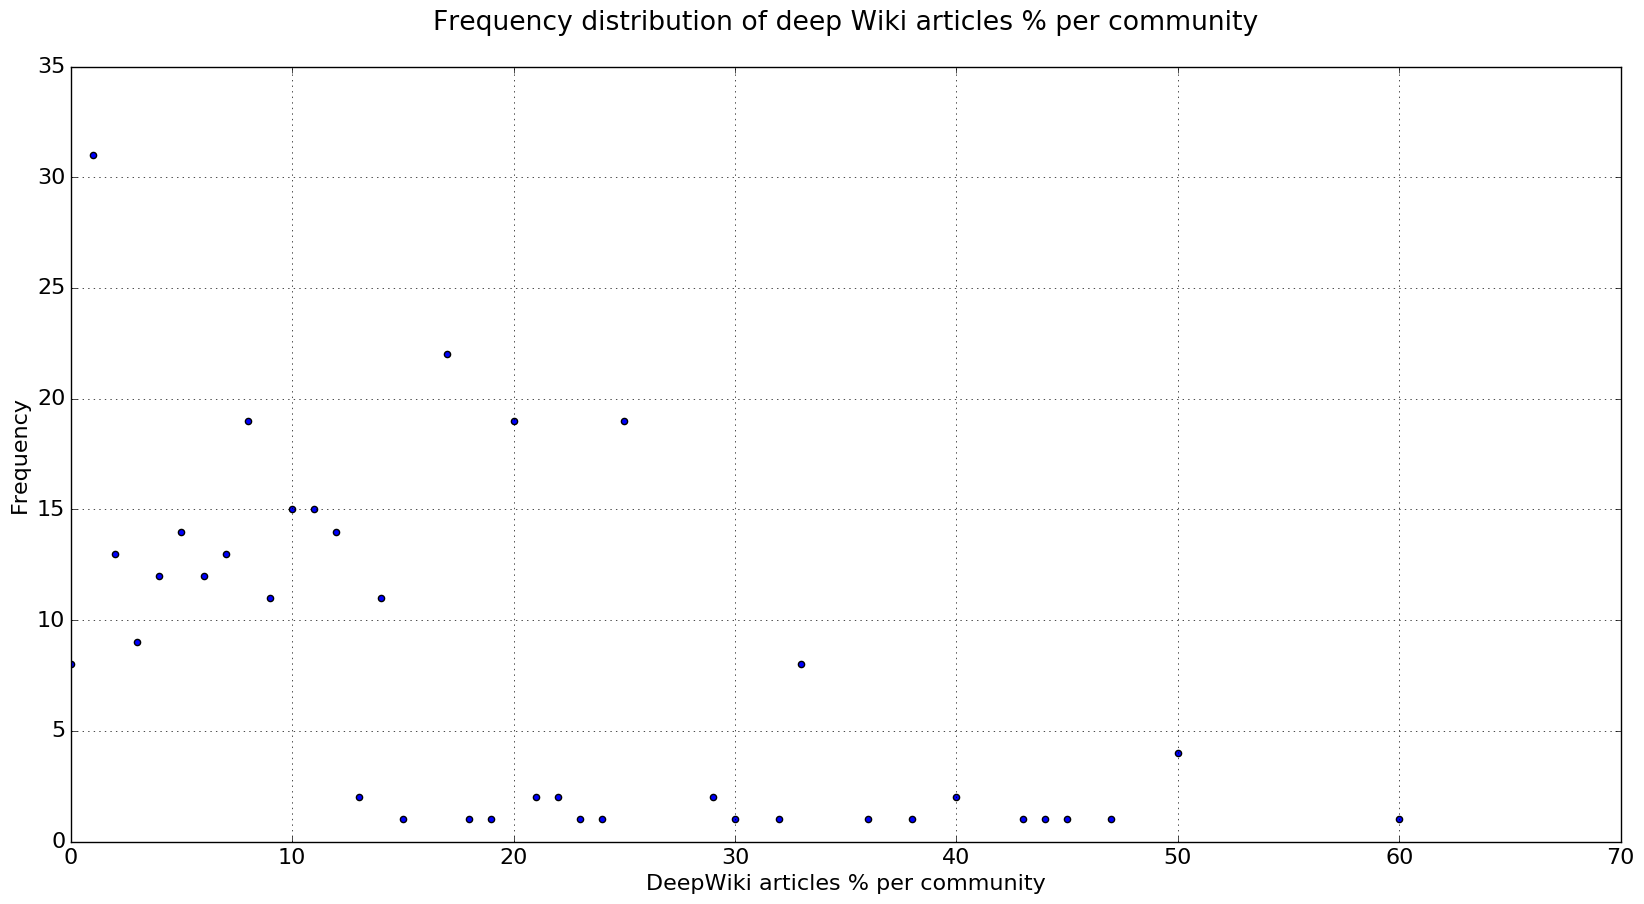

In [62]:
quick_plot(deep_wiki_pct_freq, "Frequency distribution of deep Wiki articles % per community\n")

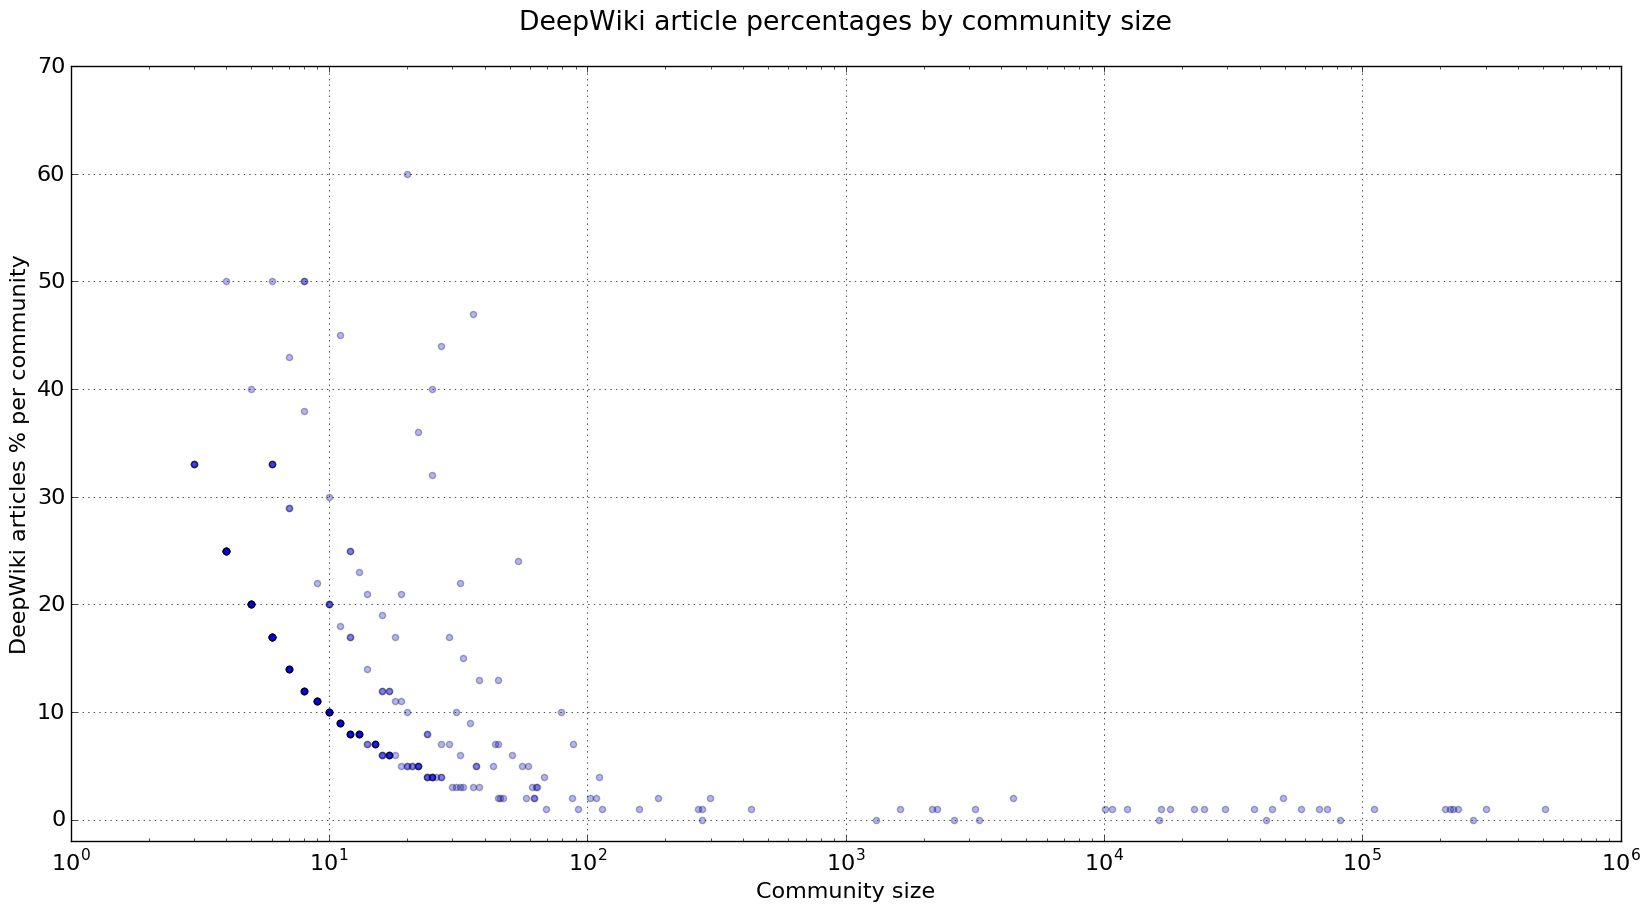

In [61]:
plt.scatter(community_deepWiki_stats.articles_count, 
            community_deepWiki_stats.deep_wiki_articles_proportion.round(2) * 100, c="b", alpha=0.3)
ax = plt.gca()
#ax.set_xlim(xmin=0)
plt.xscale("log")

ax.set_ylim(ymin=-2)
    
plt.xlabel('Community size')
plt.ylabel('DeepWiki articles % per community')
plt.grid(True)
plt.title("DeepWiki article percentages by community size\n");

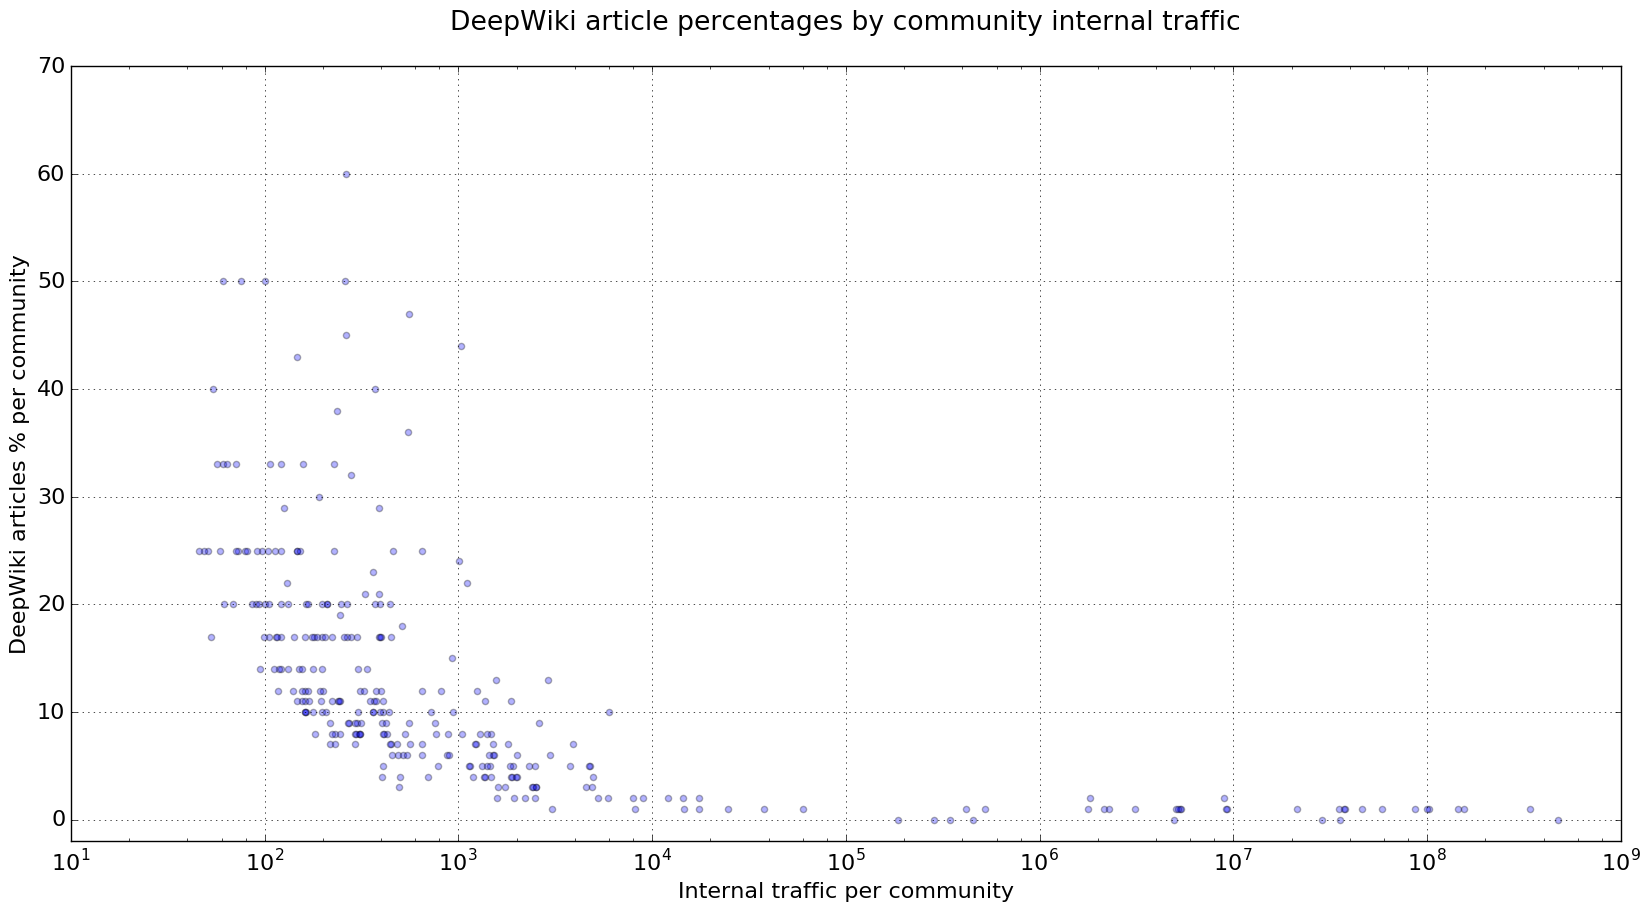

In [60]:
plt.scatter(community_deepWiki_stats.total_internal_visits, 
            community_deepWiki_stats.deep_wiki_articles_proportion.round(2) * 100, c="b", alpha=0.3)
ax = plt.gca()
#ax.set_xlim(xmin=0)
plt.xscale("log")
ax.set_ylim(ymin=-2)
   
plt.xlabel('Internal traffic per community')
plt.ylabel('DeepWiki articles % per community')
plt.grid(True)
plt.title("DeepWiki article percentages by community internal traffic\n");

In [42]:
# unpickle
with open("pickles/en_1218_louvain_communities.pkl", 'rb') as picklefile: 
    louvain_communities = pickle.load(picklefile)

louvain_communities.head()

,articles_count,external_search_traffic,link_in_edges_count,link_in_traffic,louvain_community,search_in_edges_count,search_in_traffic,total_visits,link_edges_count,link_traffic,search_edges_count,search_traffic,avg_external_search_traffic,avg_overall_link_in_degree,avg_community_link_in_degree,avg_link_in_traffic_per_edge,avg_link_traffic_per_edge,avg_visits_per_article,link_network_density,link_network_density_delta,network_density,network_density_delta
0,507642,535227964,3385462,329625267,3,102124,4188154,1124655652,2740230,279916754,83923.00,3506684.00,1054.34,6.67,5.40,97.36,102.15,2215.45,0.00,4.40,0.00,4.56
1,302120,288453340,2037310,140416238,7,41383,1257742,592415339,1472052,100658886,27798.00,769867.00,954.76,6.74,4.87,68.92,68.38,1960.86,0.00,3.87,0.00,3.96
2,267541,626988532,2540296,461475849,4,98857,3938984,1350876078,2182385,423779216,83056.00,3428064.00,2343.52,9.49,8.16,181.66,194.18,5049.23,0.00,7.16,0.00,7.47
3,233396,150495954,1209989,84128861,10,25894,932688,322074785,839295,54133551,17677.00,581906.00,644.81,5.18,3.60,69.53,64.50,1379.95,0.00,2.60,0.00,2.67
4,223864,219874886,1327054,151652674,5,32332,930331,468611692,1141537,132364916,23895.00,663439.00,982.18,5.93,5.10,114.28,115.95,2093.29,0.00,4.10,0.00,4.21


In [43]:
network_densities = louvain_communities[["louvain_community", "link_network_density", "link_network_density_delta",
                                            "network_density", "network_density_delta"]]
network_densities.set_index("louvain_community", inplace=True)

In [44]:
community_deepWiki_stats = community_deepWiki_stats.join(network_densities)

In [45]:
community_deepWiki_stats.head()

,deep_wiki_articles_count,articles_count,deep_wiki_articles_proportion,deep_wiki_internal_visits,total_internal_visits,deep_wiki_internal_visits_proportion,deep_wiki_link_in_traffic,link_in_traffic,deep_wiki_link_in_traffic_proportion,deep_wiki_search_in_traffic,search_in_traffic,deep_wiki_search_in_traffic_proportion,topic_words,link_network_density,link_network_density_delta,network_density,network_density_delta
louvain_community,,,,,,,,,,,,,,,,,
0,248,29397,0.01,3435,5306439,0.00,3414,5057107,0.00,21,29778,0.00,station railway class line rail metro list park train transport british london south road tram c...,0.00,2.29,0.00,2.32
1,1099,218001,0.01,19950,101941984,0.00,19691,95420595,0.00,259,1056534,0.00,list disambigu softwar power station number engin space unit program network model theorem group...,0.00,4.66,0.00,4.79
2,2423,209065,0.01,39438,100235624,0.00,38916,96546076,0.00,522,1568306,0.00,list disambigu syndrom nation park diseas food black acid hospit state red white cell medic dog ...,0.00,4.05,0.00,4.23
3,3860,507642,0.01,64629,339915502,0.00,62693,329625267,0.00,1916,4188154,0.00,list unit state footbal elect nation th constitu parti battl john film st district war cup disam...,0.00,4.40,0.00,4.56
4,1020,267541,0.00,18366,472694667,0.00,18132,461475849,0.00,234,3938984,0.00,film list seri tv actor comic season award disambigu episod school john charact novel man star l...,0.00,7.16,0.00,7.47


In [46]:
community_deepWiki_stats[community_deepWiki_stats.network_density > 1]

,deep_wiki_articles_count,articles_count,deep_wiki_articles_proportion,deep_wiki_internal_visits,total_internal_visits,deep_wiki_internal_visits_proportion,deep_wiki_link_in_traffic,link_in_traffic,deep_wiki_link_in_traffic_proportion,deep_wiki_search_in_traffic,search_in_traffic,deep_wiki_search_in_traffic_proportion,topic_words,link_network_density,link_network_density_delta,network_density,network_density_delta
louvain_community,,,,,,,,,,,,,,,,,


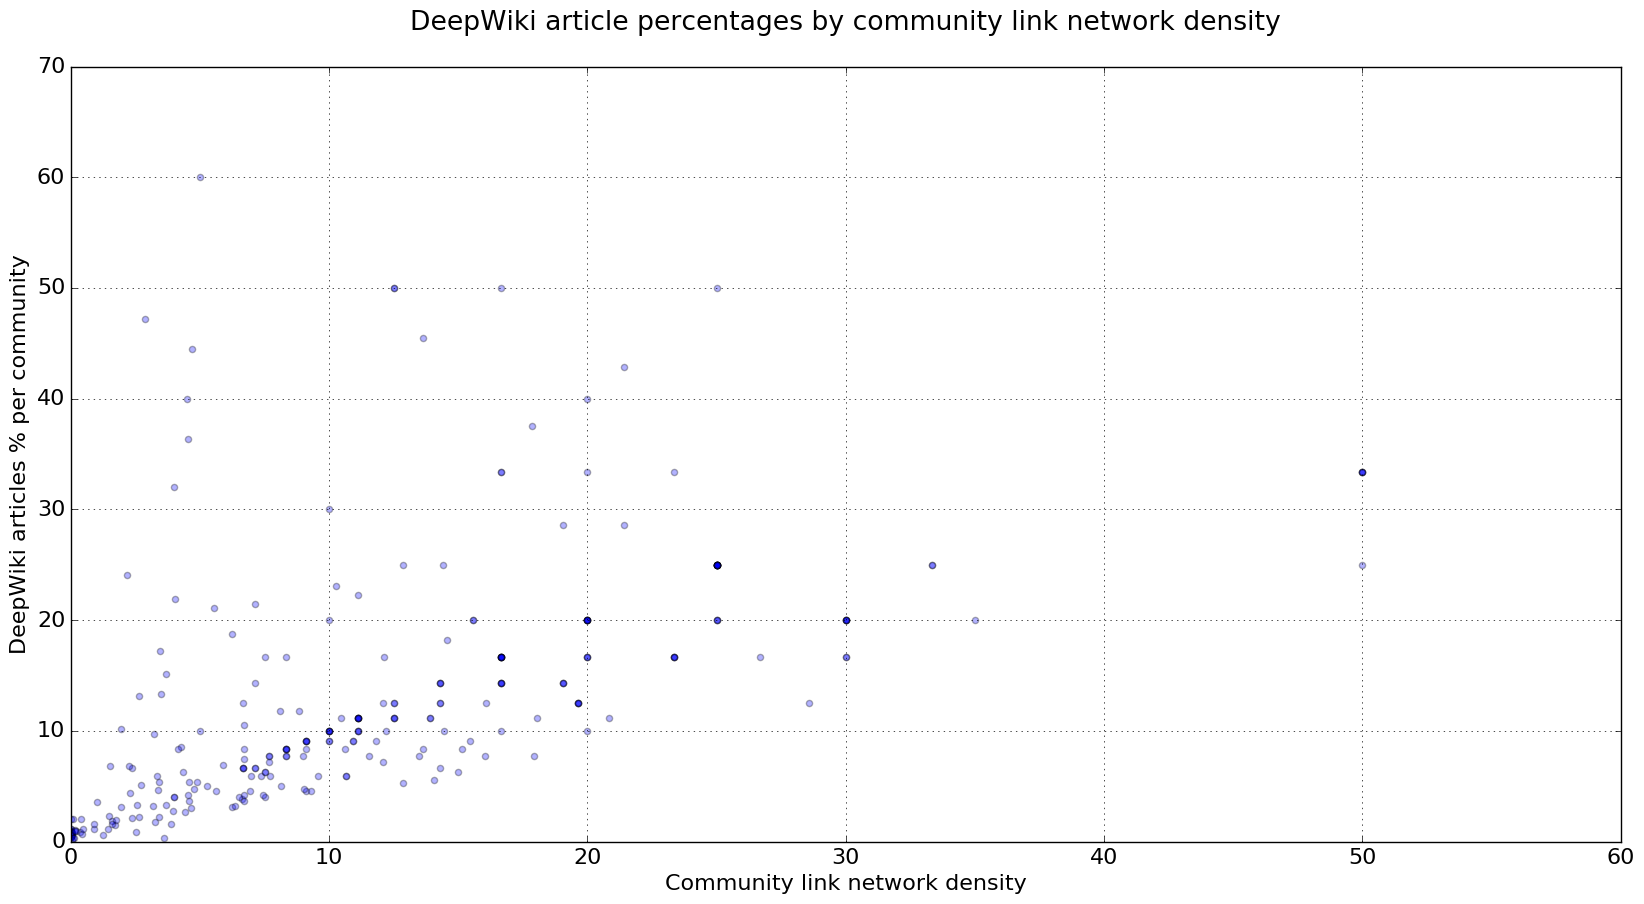

In [58]:
plt.scatter(community_deepWiki_stats.network_density.round(6) * 100, 
            community_deepWiki_stats.deep_wiki_articles_proportion.round(4) * 100, c="b", alpha=0.3)
ax = plt.gca()
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
    
plt.xlabel('Community link network density')
plt.ylabel('DeepWiki articles % per community')
plt.grid(True)
plt.title("DeepWiki article percentages by community link network density\n");

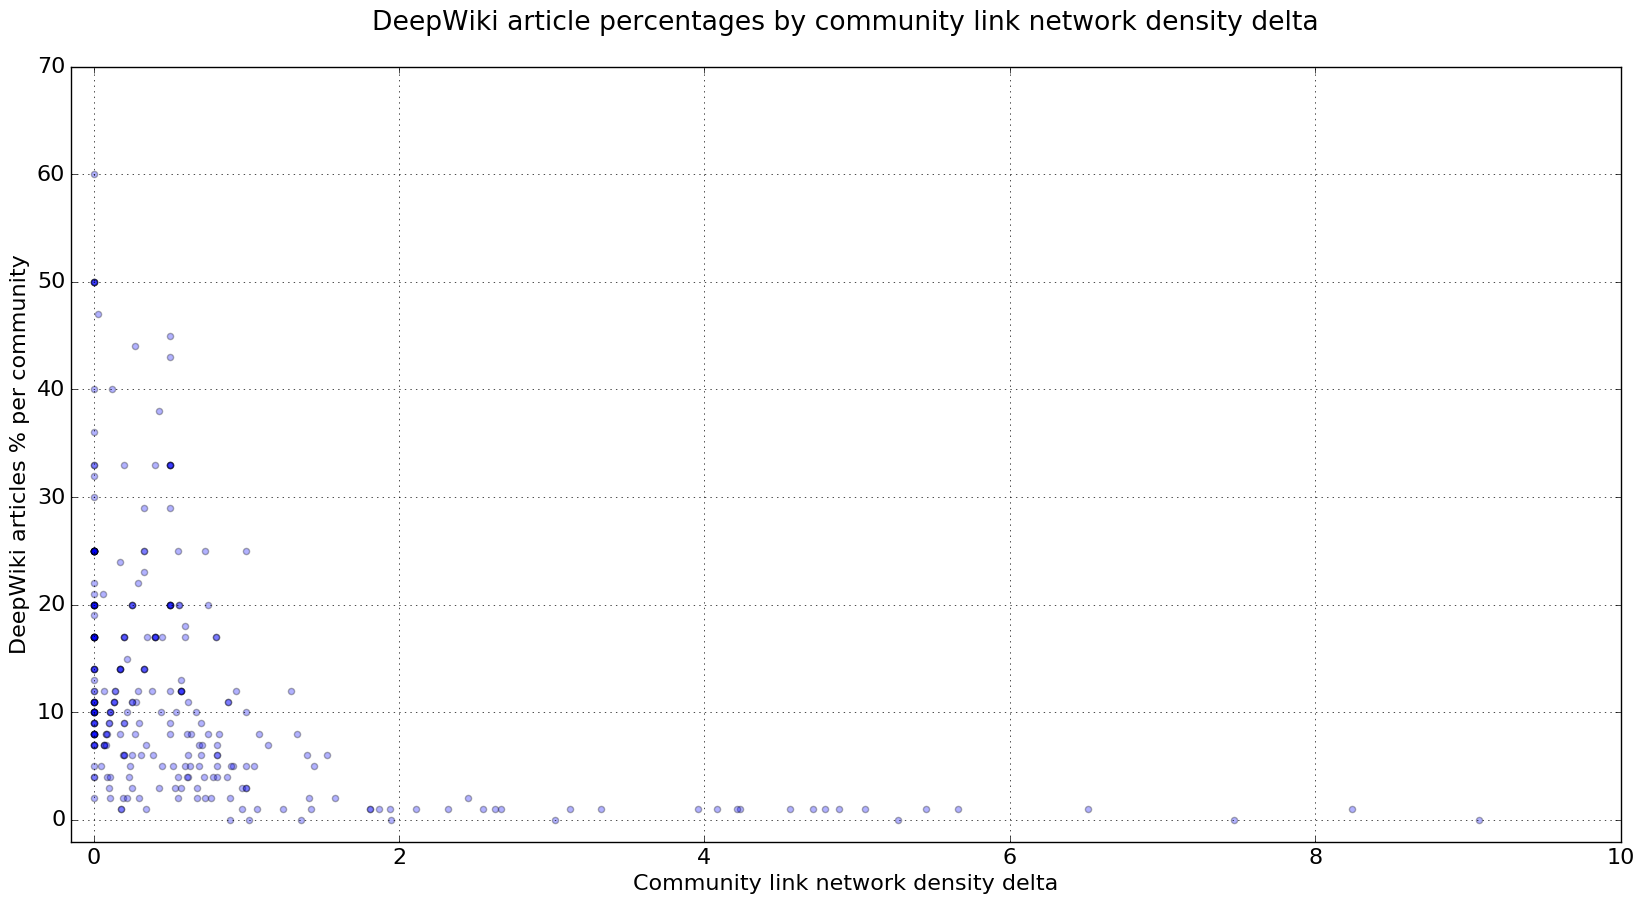

In [69]:
plt.scatter(community_deepWiki_stats.network_density_delta.round(2), 
            community_deepWiki_stats.deep_wiki_articles_proportion.round(2) * 100, c="b", alpha=0.3)
ax = plt.gca()
ax.set_xlim(xmin=-0.15)
ax.set_ylim(ymin=-2)
    
plt.xlabel('Community link network density delta')
plt.ylabel('DeepWiki articles % per community')
plt.grid(True)
plt.title("DeepWiki article percentages by community link network density delta\n");

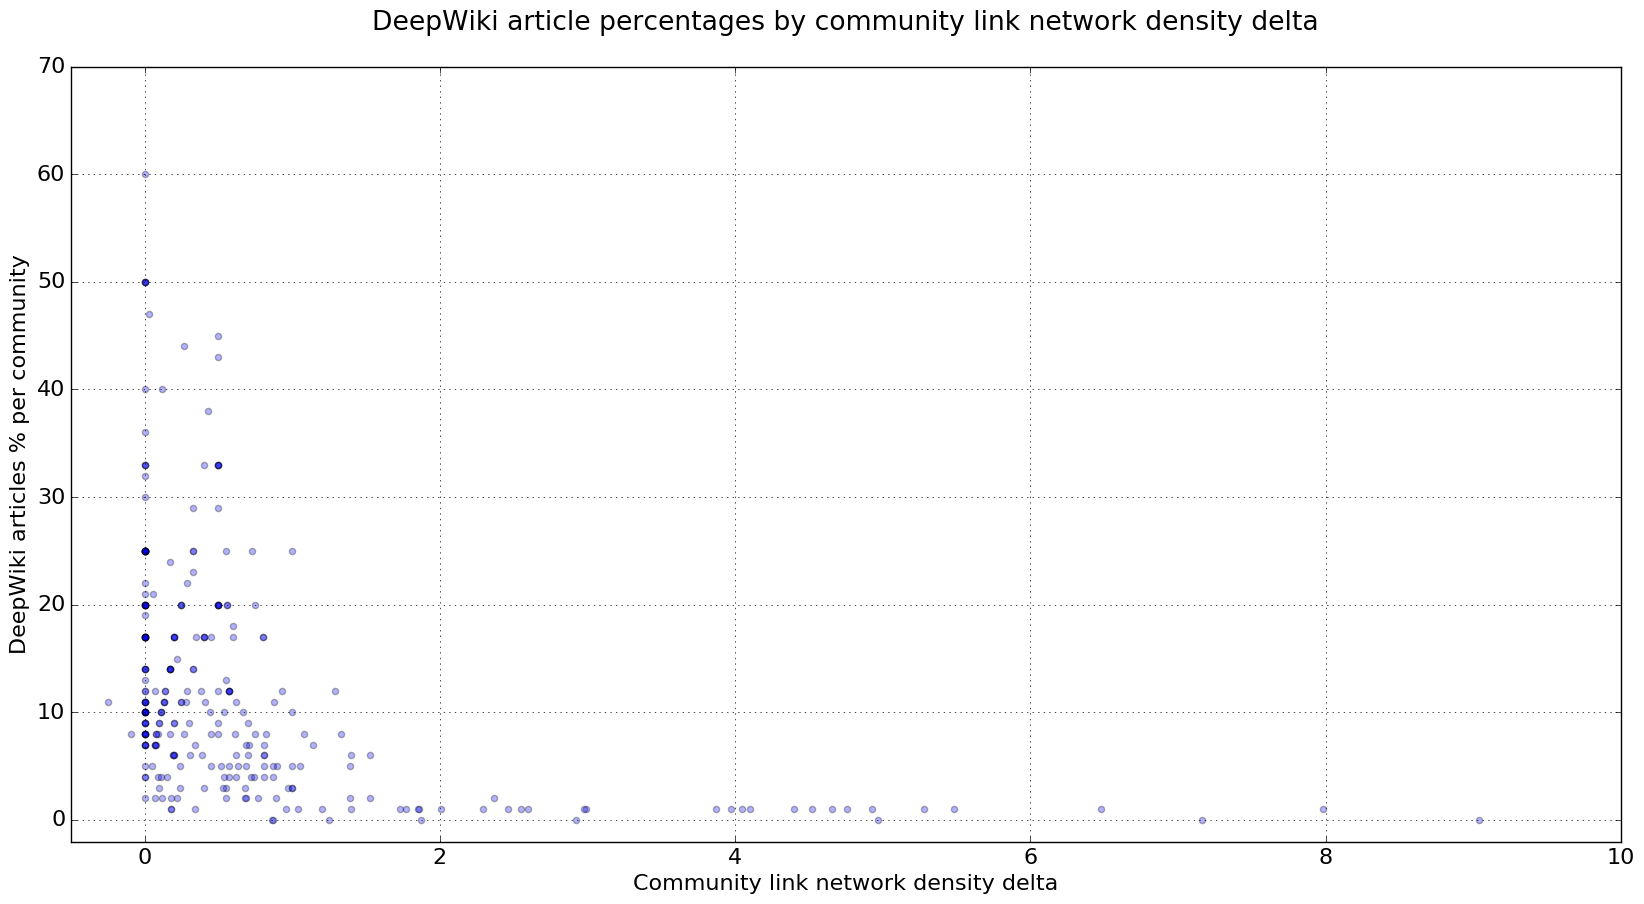

In [72]:
plt.scatter(community_deepWiki_stats.link_network_density_delta.round(2), 
            community_deepWiki_stats.deep_wiki_articles_proportion.round(2) * 100, c="b", alpha=0.3)
ax = plt.gca()
ax.set_xlim(xmin=-0.5)
ax.set_ylim(ymin=-2)
    
plt.xlabel('Community link network density delta')
plt.ylabel('DeepWiki articles % per community')
plt.grid(True)
plt.title("DeepWiki article percentages by community link network density delta\n");

In [76]:
# pickle the output
myoutfile = "pickles/en_1218_community_deepWiki_stats.pkl"
with open(myoutfile, 'wb') as picklefile:
    pickle.dump(community_deepWiki_stats, picklefile)

print("Pickle created: " + myoutfile)

Pickle created: pickles/en_1218_community_deepWiki_stats.pkl


In [77]:
# unpickle
with open("pickles/en_1218_community_deepWiki_stats.pkl", 'rb') as picklefile: 
    community_deepWiki_stats = pickle.load(picklefile)

community_deepWiki_stats.head()

,deep_wiki_articles_count,articles_count,deep_wiki_articles_proportion,deep_wiki_internal_visits,total_internal_visits,deep_wiki_internal_visits_proportion,deep_wiki_link_in_traffic,link_in_traffic,deep_wiki_link_in_traffic_proportion,deep_wiki_search_in_traffic,search_in_traffic,deep_wiki_search_in_traffic_proportion,topic_words,link_network_density,link_network_density_delta,network_density,network_density_delta
louvain_community,,,,,,,,,,,,,,,,,
0,248,29397,0.01,3435,5306439,0.00,3414,5057107,0.00,21,29778,0.00,station railway class line rail metro list park train transport british london south road tram c...,0.00,2.29,0.00,2.32
1,1099,218001,0.01,19950,101941984,0.00,19691,95420595,0.00,259,1056534,0.00,list disambigu softwar power station number engin space unit program network model theorem group...,0.00,4.66,0.00,4.79
2,2423,209065,0.01,39438,100235624,0.00,38916,96546076,0.00,522,1568306,0.00,list disambigu syndrom nation park diseas food black acid hospit state red white cell medic dog ...,0.00,4.05,0.00,4.23
3,3860,507642,0.01,64629,339915502,0.00,62693,329625267,0.00,1916,4188154,0.00,list unit state footbal elect nation th constitu parti battl john film st district war cup disam...,0.00,4.40,0.00,4.56
4,1020,267541,0.00,18366,472694667,0.00,18132,461475849,0.00,234,3938984,0.00,film list seri tv actor comic season award disambigu episod school john charact novel man star l...,0.00,7.16,0.00,7.47


### 3.3 Deep Wiki shell decomposition

Let's decompose the deep Wiki nodes to find how far from external sources have users browsed Wikipedia articles.

In [73]:
deep_wiki_nodes = nodes_for_deep_wiki[nodes_for_deep_wiki.total_external_visits == 0].copy()

In [75]:
deep_wiki_nodes.describe()

,empty_referer_traffic,external_search_traffic,external_website_traffic,link_in_traffic,louvain_community,other_wikimedia_traffic,search_in_traffic,search_traffic_from_main_page,unknown_external_traffic,total_external_visits,total_internal_visits
count,20925.00,20925.00,20925.00,20925.00,20925.00,20925.00,20925.00,20925.00,20925.00,20925.00,20925.00
mean,0.00,0.00,0.00,16.98,22.56,0.00,0.28,0.02,0.00,0.00,17.27
std,0.00,0.00,0.00,12.34,123.87,0.00,2.46,1.43,0.00,0.00,12.31
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,11.00,3.00,0.00,0.00,0.00,0.00,0.00,11.00
50%,0.00,0.00,0.00,14.00,5.00,0.00,0.00,0.00,0.00,0.00,14.00
75%,0.00,0.00,0.00,21.00,10.00,0.00,0.00,0.00,0.00,0.00,21.00
max,0.00,0.00,0.00,207.00,1697.00,0.00,66.00,201.00,0.00,0.00,207.00


Get deepWiki edges

In [10]:
# get a listing of all Louvain communities and their stats
start_time = timer()
q = """
    MATCH (a1:Article)-->(a2:Article)
    WHERE not exists(a2.external_search_traffic)
        AND not exists(a2.external_website_traffic)
        AND not exists(a2.unknown_external_traffic)
        AND not exists(a2.empty_referer_traffic)
        AND not exists(a2.other_wikimedia_traffic)
    RETURN 
        a1.title as from_title,
        (coalesce(a1.external_search_traffic, 0)
        + coalesce(a1.external_website_traffic, 0)
        + coalesce(a1.unknown_external_traffic, 0)
        + coalesce(a1.empty_referer_traffic, 0)
        + coalesce(a1.other_wikimedia_traffic, 0) ) as from_external_traffic,
        a2.title as to_title
        ;
    """

r = graph.data(q)
deep_wiki_edges = pd.DataFrame(r)

print("Number of edges:",len(deep_wiki_edges))

cu.printRunTime(start_time)

Number of edges: 21893


Runtime: 0.47 min



In [11]:
deep_wiki_edges.head(10)

,from_external_traffic,from_title,to_title
0,4825,United_States_Strategic_Command,Strategic_Command_(disambiguation)
1,24,"John_Lyon,_6th_Lord_Glamis","John_Lyon,_4th_Lord_Glamis"
2,41,"John_Lyon,_3rd_Lord_Glamis","John_Lyon,_4th_Lord_Glamis"
3,1257,Earl_of_Strathmore_and_Kinghorne,"John_Lyon,_4th_Lord_Glamis"
4,1925,United_Front_(China),United_Front_(China)_(disambiguation)
5,75,Frank_Mancuso,Frank_Mancuso_(disambiguation)
6,1932,"Sovetsk,_Kaliningrad_Oblast",Tilsit_(disambiguation)
7,2305,Dramarama,Dramarama_(disambiguation)
8,2216,Duchy_of_Schleswig,Schleswig_(disambiguation)
9,199,USS_Grenadier_(SS-210),USS_Grenadier


In [12]:
deep_wiki_edges.fillna(0, inplace=True)

In [13]:
deep_wiki_edges.head(10)

,from_external_traffic,from_title,to_title
0,4825,United_States_Strategic_Command,Strategic_Command_(disambiguation)
1,24,"John_Lyon,_6th_Lord_Glamis","John_Lyon,_4th_Lord_Glamis"
2,41,"John_Lyon,_3rd_Lord_Glamis","John_Lyon,_4th_Lord_Glamis"
3,1257,Earl_of_Strathmore_and_Kinghorne,"John_Lyon,_4th_Lord_Glamis"
4,1925,United_Front_(China),United_Front_(China)_(disambiguation)
5,75,Frank_Mancuso,Frank_Mancuso_(disambiguation)
6,1932,"Sovetsk,_Kaliningrad_Oblast",Tilsit_(disambiguation)
7,2305,Dramarama,Dramarama_(disambiguation)
8,2216,Duchy_of_Schleswig,Schleswig_(disambiguation)
9,199,USS_Grenadier_(SS-210),USS_Grenadier


In [14]:
len(deep_wiki_edges[deep_wiki_edges.from_external_traffic == 0])

227

In [15]:
deep_wiki_edges_decomp = deep_wiki_edges.to_dict(orient='records')

In [16]:
deep_wiki_edges_decomp[:5]

[{'from_external_traffic': 4825,
  'from_title': 'United_States_Strategic_Command',
  'to_title': 'Strategic_Command_(disambiguation)'},
 {'from_external_traffic': 24,
  'from_title': 'John_Lyon,_6th_Lord_Glamis',
  'to_title': 'John_Lyon,_4th_Lord_Glamis'},
 {'from_external_traffic': 41,
  'from_title': 'John_Lyon,_3rd_Lord_Glamis',
  'to_title': 'John_Lyon,_4th_Lord_Glamis'},
 {'from_external_traffic': 1257,
  'from_title': 'Earl_of_Strathmore_and_Kinghorne',
  'to_title': 'John_Lyon,_4th_Lord_Glamis'},
 {'from_external_traffic': 1925,
  'from_title': 'United_Front_(China)',
  'to_title': 'United_Front_(China)_(disambiguation)'}]

In [30]:

print("Started running at", datetime.now(), "UTC")
start_time = timer()


deep_wiki_edges_decomp = deep_wiki_edges.to_dict(orient='records')

shells = {}
i = 0
go = 1

while(go):
    print("i =", i)
    print("Decomposition edges list length:", len(deep_wiki_edges_decomp))
    shell_arr = []
    shell_indexes = []
    for j in range(len(deep_wiki_edges_decomp)):
        if deep_wiki_edges_decomp[j]["from_external_traffic"] > 0:
            shell_arr.append(deep_wiki_edges_decomp[j]["from_title"])
            shell_indexes.append(j)
            
    new_terminal_nodes = []
    for k in shell_indexes:
        shelled_to_title = deep_wiki_edges_decomp[k].get("to_title", "")
        if not (shelled_to_title in shell_arr) and (shelled_to_title != ""):
            new_terminal_node_check = 1
            for m in range(len(deep_wiki_edges_decomp)):
                if deep_wiki_edges_decomp[m]["from_title"] == shelled_to_title:
                    new_terminal_node_check = 0
                    deep_wiki_edges_decomp[m]["from_external_traffic"] += deep_wiki_edges_decomp[k]["from_external_traffic"]
            if new_terminal_node_check == 1:
                new_terminal_nodes.append(
                    { 'from_external_traffic': deep_wiki_edges_decomp[k]["from_external_traffic"],
                      'from_title': shelled_to_title
                    })
        
        
    
    deep_wiki_edges_decomp = list(np.delete(deep_wiki_edges_decomp, shell_indexes))
    deep_wiki_edges_decomp.extend(new_terminal_nodes)
    print("Removed edges count = ", len(shell_indexes))
    print("Added new terminal edges count = ", len(new_terminal_nodes))
                   
    shells[i] = shell_arr
    
    
    # stopping condition
    if (len(deep_wiki_edges_decomp) == 0) or not (any(d["from_external_traffic"] > 0 for d in deep_wiki_edges_decomp)):
        go = 0
    else: 
        i += 1
    
        


cu.printRunTime(start_time)

print("Number of steps from external traffic boundary:", i)

Started running at 2019-03-06 18:30:53.498047 UTC
i = 0
Decomposition edges list length: 21893
Removed edges count =  21666
Added new terminal edges count =  21500
i = 1
Decomposition edges list length: 21727
Removed edges count =  21649
Added new terminal edges count =  87
i = 2
Decomposition edges list length: 165
Removed edges count =  108
Added new terminal edges count =  17
i = 3
Decomposition edges list length: 74
Removed edges count =  21
Added new terminal edges count =  3
i = 4
Decomposition edges list length: 56
Removed edges count =  4
Added new terminal edges count =  0
i = 5
Decomposition edges list length: 52
Removed edges count =  1
Added new terminal edges count =  0
i = 6
Decomposition edges list length: 51
Removed edges count =  1
Added new terminal edges count =  1
i = 7
Decomposition edges list length: 51
Removed edges count =  1
Added new terminal edges count =  0


Runtime: 1.88 min

Number of steps from external traffic boundary: 7


In [31]:
len(shells[0])

21666

In [32]:
shells[2][:5]

['1950_Kansas_State_Wildcats_football_team',
 '1991_UK_Athletics_Championships',
 '1912_Northwestern_Purple_football_team',
 'For_All_Slaves_a_Song_of_False_Hope',
 '2004_United_Kingdom_budget']

In [33]:
total_shells_count = 0
for i in range(len(shells)):
    print("Shell", i, "size = ", len(shells[i]))
    total_shells_count += len(shells[i])
    
print(total_shells_count)

Shell 0 size =  21666
Shell 1 size =  21649
Shell 2 size =  108
Shell 3 size =  21
Shell 4 size =  4
Shell 5 size =  1
Shell 6 size =  1
Shell 7 size =  1
43451


In [34]:
total_shells_count = 0
for i in range(len(shells)):
    print("Shell", i, "size = ", len(set(shells[i]) ))
    total_shells_count += len(set(shells[i]))
    
    if len(set(shells[i])) < 10:
        print(set(shells[i]))
    
print(total_shells_count)

Shell 0 size =  19040
Shell 1 size =  20470
Shell 2 size =  107
Shell 3 size =  21
Shell 4 size =  4
{'2002_VMI_Keydets_football_team', 'Rend_Each_Other_Like_Wild_Beasts,_Till_Earth_Shall_Reek_With_Midnight_Massacre', '1919_Sewanee_Tigers_football_team', 'Land_2_Air_Chronicles_II:_Imitation_Is_Suicide_Chapter_3'}
Shell 5 size =  1
{'2001_VMI_Keydets_football_team'}
Shell 6 size =  1
{'2000_VMI_Keydets_football_team'}
Shell 7 size =  1
{'1999_VMI_Keydets_football_team'}
39645


In [35]:
remaining_from_titles = []
remaining_to_titles = []

for ed in range(len(deep_wiki_edges_decomp)):
    if deep_wiki_edges_decomp[ed].get("from_external_traffic", 0) > 0:
        print("Found ext traffic > 0 at", ed)
        print(deep_wiki_edges_decomp[ed])
        
    remaining_from_titles.append(deep_wiki_edges_decomp[ed].get("from_title", ""))
    to_title = deep_wiki_edges_decomp[ed].get("to_title", "")
    if to_title != "":
        remaining_to_titles.append(to_title)

In [41]:
len(remaining_from_titles)

50

In [42]:
len(set(remaining_from_titles))

50

In [43]:
len(remaining_to_titles)

50

In [44]:
len(set(remaining_to_titles))

50

In [37]:
len(set(remaining_from_titles).union(set(remaining_to_titles)))

96

In [38]:
len(deep_wiki_edges_decomp)

50

In [39]:
deep_wiki_edges_decomp[:5]

[{'from_external_traffic': 0,
  'from_title': 'List_of_lymantriid_genera:_C',
  'to_title': 'List_of_lymantriid_genera:_D'},
 {'from_external_traffic': 0,
  'from_title': '1931_Michigan_State_Spartans_football_team',
  'to_title': '1932_Michigan_State_Spartans_football_team'},
 {'from_external_traffic': 0,
  'from_title': '1906_USC_Methodists_football_team',
  'to_title': '1907_USC_Methodists_football_team'},
 {'from_external_traffic': 0,
  'from_title': '1928_Auburn_Tigers_football_team',
  'to_title': '1929_Auburn_Tigers_football_team'},
 {'from_external_traffic': 0,
  'from_title': 'List_of_lymantriid_genera:_D',
  'to_title': 'List_of_lymantriid_genera:_B'}]

In [52]:
q = """
    MATCH (a:Article)
    WHERE a.title = '1999_VMI_Keydets_football_team'
    RETURN a
        ;
    """

r = graph.data(q)
farthest_article = pd.DataFrame(r)

print(farthest_article.a.values[0])


(faa4b66:Article {artrank:0.16292850000000006,cc_partition:3890074,link_cc_partition:3892092,link_in_degree:1,link_in_traffic:11,link_out_degree:1,link_out_traffic:11,louvain_communities:[245078,35,12,11,11],louvain_community:11,pagerank:0.15000000000000002,search_in_degree:0,search_out_degree:0,title:"1999_VMI_Keydets_football_team"})


### 3.4 Finding the clickstream path to the farthest deep Wiki article

In [60]:
# Script to run in neo4j cypher shell
s = """
    MATCH p=(a0:Article)-[*7]->(a7:Article)
    WHERE a7.title = '1999_VMI_Keydets_football_team'
        AND (   exists(a0.external_search_traffic)
                OR exists(a0.external_website_traffic)
                OR exists(a0.unknown_external_traffic)
                OR exists(a0.empty_referer_traffic)
                OR exists(a0.other_wikimedia_traffic)
            )
    RETURN p
        ;
    """

with open("path_to_farthest_deepwiki_node.cypher", "w") as f:
    f.write(s)

Run the above cypher script in terminal with nohup:  
```
passwd=$(bash get_n4j_pass.sh)
nohup cat path_to_farthest_deepwiki_node.cypher | cypher-shell -u neo4j -p $passwd --format plain &> path_to_farthest_deepwiki_node.out
```
_runtime: <1 min_


In [99]:
! head path_to_farthest_deepwiki_node.out

p
(:Article {link_in_degree: 1, link_in_traffic: 12, link_cc_partition: 3892092, search_out_degree: 0, louvain_communities: [245078, 35, 12, 11, 11], title: "2006_VMI_Keydets_football_team", link_out_degree: 1, search_in_degree: 0, artrank: 0.16292850000000006, link_out_traffic: 13, louvain_community: 11, cc_partition: 3890074, empty_referer_traffic: 10, pagerank: 0.15000000000000002})-[:LINK_TO {traffic: 13}]->(:Article {link_in_degree: 1, link_in_traffic: 13, link_cc_partition: 3892092, search_out_degree: 0, louvain_communities: [245078, 35, 12, 11, 11], title: "2005_VMI_Keydets_football_team", link_out_degree: 1, search_in_degree: 0, artrank: 0.16292850000000006, louvain_community: 11, link_out_traffic: 14, cc_partition: 3890074, pagerank: 0.15000000000000002})-[:LINK_TO {traffic: 14}]->(:Article {link_in_degree: 1, link_in_traffic: 14, link_cc_partition: 3892092, search_out_degree: 0, louvain_communities: [245078, 35, 12, 11, 11], title: "2004_VMI_Keydets_football_team", link_out_d

In [118]:
filepath = 'path_to_farthest_deepwiki_node.out'  

with open(filepath) as fp:  
    line = fp.readline()
    i = 1
    while line:
        print("Line {}: {}".format(i, line.strip()))
        line = fp.readline()
        i += 1

Line 1: p
Line 2: (:Article {link_in_degree: 1, link_in_traffic: 12, link_cc_partition: 3892092, search_out_degree: 0, louvain_communities: [245078, 35, 12, 11, 11], title: "2006_VMI_Keydets_football_team", link_out_degree: 1, search_in_degree: 0, artrank: 0.16292850000000006, link_out_traffic: 13, louvain_community: 11, cc_partition: 3890074, empty_referer_traffic: 10, pagerank: 0.15000000000000002})-[:LINK_TO {traffic: 13}]->(:Article {link_in_degree: 1, link_in_traffic: 13, link_cc_partition: 3892092, search_out_degree: 0, louvain_communities: [245078, 35, 12, 11, 11], title: "2005_VMI_Keydets_football_team", link_out_degree: 1, search_in_degree: 0, artrank: 0.16292850000000006, louvain_community: 11, link_out_traffic: 14, cc_partition: 3890074, pagerank: 0.15000000000000002})-[:LINK_TO {traffic: 14}]->(:Article {link_in_degree: 1, link_in_traffic: 14, link_cc_partition: 3892092, search_out_degree: 0, louvain_communities: [245078, 35, 12, 11, 11], title: "2004_VMI_Keydets_football_t

In [119]:

with open(filepath) as fp:  
    line = fp.readline()
    i = 1
    while line:
        if i == 2:
            path_str = line.strip()
        
        line = fp.readline()
        i += 1
        
path_str

'(:Article {link_in_degree: 1, link_in_traffic: 12, link_cc_partition: 3892092, search_out_degree: 0, louvain_communities: [245078, 35, 12, 11, 11], title: "2006_VMI_Keydets_football_team", link_out_degree: 1, search_in_degree: 0, artrank: 0.16292850000000006, link_out_traffic: 13, louvain_community: 11, cc_partition: 3890074, empty_referer_traffic: 10, pagerank: 0.15000000000000002})-[:LINK_TO {traffic: 13}]->(:Article {link_in_degree: 1, link_in_traffic: 13, link_cc_partition: 3892092, search_out_degree: 0, louvain_communities: [245078, 35, 12, 11, 11], title: "2005_VMI_Keydets_football_team", link_out_degree: 1, search_in_degree: 0, artrank: 0.16292850000000006, louvain_community: 11, link_out_traffic: 14, cc_partition: 3890074, pagerank: 0.15000000000000002})-[:LINK_TO {traffic: 14}]->(:Article {link_in_degree: 1, link_in_traffic: 14, link_cc_partition: 3892092, search_out_degree: 0, louvain_communities: [245078, 35, 12, 11, 11], title: "2004_VMI_Keydets_football_team", link_out_de

In [165]:
path_str_clean = path_str
path_str_clean[:700]

'(:Article {link_in_degree: 1, link_in_traffic: 12, link_cc_partition: 3892092, search_out_degree: 0, louvain_communities: [245078, 35, 12, 11, 11], title: "2006_VMI_Keydets_football_team", link_out_degree: 1, search_in_degree: 0, artrank: 0.16292850000000006, link_out_traffic: 13, louvain_community: 11, cc_partition: 3890074, empty_referer_traffic: 10, pagerank: 0.15000000000000002})-[:LINK_TO {traffic: 13}]->(:Article {link_in_degree: 1, link_in_traffic: 13, link_cc_partition: 3892092, search_out_degree: 0, louvain_communities: [245078, 35, 12, 11, 11], title: "2005_VMI_Keydets_football_team", link_out_degree: 1, search_in_degree: 0, artrank: 0.16292850000000006, louvain_community: 11, link'

In [166]:
# convert the path string to json
to_replace = r'^\(:Article '
replace_with = r'['
path_str_clean = re.sub(to_replace, replace_with, path_str_clean)

to_replace = r'\)-\[:((LINK_TO)|(SEARCH_FOR)) {traffic: \d\d}\]->\(:Article '
replace_with = r','
path_str_clean = re.sub(to_replace, replace_with, path_str_clean)

to_replace = r'\)$'
replace_with = r']'
path_str_clean = re.sub(to_replace, replace_with, path_str_clean)

# put the keys inside quotes
to_replace = r'((?<={)|(?<=(, )))(\w+)(?=:)'
replace_with = r'"\3"'
path_str_clean = re.sub(to_replace, replace_with, path_str_clean)


path_str_clean

'[{"link_in_degree": 1, "link_in_traffic": 12, "link_cc_partition": 3892092, "search_out_degree": 0, "louvain_communities": [245078, 35, 12, 11, 11], "title": "2006_VMI_Keydets_football_team", "link_out_degree": 1, "search_in_degree": 0, "artrank": 0.16292850000000006, "link_out_traffic": 13, "louvain_community": 11, "cc_partition": 3890074, "empty_referer_traffic": 10, "pagerank": 0.15000000000000002},{"link_in_degree": 1, "link_in_traffic": 13, "link_cc_partition": 3892092, "search_out_degree": 0, "louvain_communities": [245078, 35, 12, 11, 11], "title": "2005_VMI_Keydets_football_team", "link_out_degree": 1, "search_in_degree": 0, "artrank": 0.16292850000000006, "louvain_community": 11, "link_out_traffic": 14, "cc_partition": 3890074, "pagerank": 0.15000000000000002},{"link_in_degree": 1, "link_in_traffic": 14, "link_cc_partition": 3892092, "search_out_degree": 0, "louvain_communities": [245078, 35, 12, 11, 11], "title": "2004_VMI_Keydets_football_team", "link_out_degree": 1, "searc

In [167]:
print(path_str_clean)

[{"link_in_degree": 1, "link_in_traffic": 12, "link_cc_partition": 3892092, "search_out_degree": 0, "louvain_communities": [245078, 35, 12, 11, 11], "title": "2006_VMI_Keydets_football_team", "link_out_degree": 1, "search_in_degree": 0, "artrank": 0.16292850000000006, "link_out_traffic": 13, "louvain_community": 11, "cc_partition": 3890074, "empty_referer_traffic": 10, "pagerank": 0.15000000000000002},{"link_in_degree": 1, "link_in_traffic": 13, "link_cc_partition": 3892092, "search_out_degree": 0, "louvain_communities": [245078, 35, 12, 11, 11], "title": "2005_VMI_Keydets_football_team", "link_out_degree": 1, "search_in_degree": 0, "artrank": 0.16292850000000006, "louvain_community": 11, "link_out_traffic": 14, "cc_partition": 3890074, "pagerank": 0.15000000000000002},{"link_in_degree": 1, "link_in_traffic": 14, "link_cc_partition": 3892092, "search_out_degree": 0, "louvain_communities": [245078, 35, 12, 11, 11], "title": "2004_VMI_Keydets_football_team", "link_out_degree": 1, "search

In [172]:
articles_in_path_to_farthest = []
json_data = json.loads(path_str_clean)
for d in json_data:
    articles_in_path_to_farthest.append(d["title"])
    for key, value in d.items():
        print(key, value)
        
print("\n\nList of article titles in the path to farthest deepWiki node:")
print(articles_in_path_to_farthest)
print("List length:", len(articles_in_path_to_farthest))

title 2006_VMI_Keydets_football_team
artrank 0.16292850000000006
link_out_degree 1
search_out_degree 0
link_in_traffic 12
pagerank 0.15000000000000002
link_out_traffic 13
louvain_communities [245078, 35, 12, 11, 11]
search_in_degree 0
cc_partition 3890074
link_cc_partition 3892092
empty_referer_traffic 10
link_in_degree 1
louvain_community 11
title 2005_VMI_Keydets_football_team
artrank 0.16292850000000006
link_out_degree 1
search_out_degree 0
link_in_traffic 13
pagerank 0.15000000000000002
link_out_traffic 14
louvain_communities [245078, 35, 12, 11, 11]
search_in_degree 0
cc_partition 3890074
link_cc_partition 3892092
link_in_degree 1
louvain_community 11
title 2004_VMI_Keydets_football_team
artrank 0.16292850000000006
link_out_degree 1
search_out_degree 0
link_in_traffic 14
pagerank 0.15000000000000002
link_out_traffic 13
louvain_communities [245078, 35, 12, 11, 11]
search_in_degree 0
cc_partition 3890074
link_cc_partition 3892092
link_in_degree 1
louvain_community 11
title 2003_VMI_

In [173]:
# pickle the output
myoutfile = "pickles/en_1218_list_of_farthest_deep_wiki_path_articles.pkl"
with open(myoutfile, 'wb') as picklefile:
    pickle.dump(articles_in_path_to_farthest, picklefile)

print("Pickle created: " + myoutfile)

Pickle created: pickles/en_1218_list_of_farthest_deep_wiki_path_articles.pkl


In [174]:
# unpickle
with open("pickles/en_1218_list_of_farthest_deep_wiki_path_articles.pkl", 'rb') as picklefile: 
    articles_in_path_to_farthest = pickle.load(picklefile)

articles_in_path_to_farthest

['2006_VMI_Keydets_football_team',
 '2005_VMI_Keydets_football_team',
 '2004_VMI_Keydets_football_team',
 '2003_VMI_Keydets_football_team',
 '2002_VMI_Keydets_football_team',
 '2001_VMI_Keydets_football_team',
 '2000_VMI_Keydets_football_team',
 '1999_VMI_Keydets_football_team']

### 4. Summary  

In this notebook, we've looked at the distribution of deep Wiki articles in the Wikipedia clickstream graph, and found the clickstream path to the farthest deep Wiki article from the surface Wiki. 

### 5. Next steps

That's it for the analyses of the English Wikipedia clickstream dataset for December 2018.  
We can visualize our finidings with D3.